# Welcome to the Photobooth Side View, Single Plant Tutorial, with an example!

Made by: Katie Murphy
Updated: May 16, 2023

In this tutorial, you will observe how to develop masks for object-of-interest that are not easily thresholded. This notebook is designed to be self-guided with exercises that will help you gain exposure to some of the other functions available in PlantCV. For reference, please visit [PlantCV's ReadtheDocs page](https://plantcv.readthedocs.io/en/stable) for more information.

## Loading Libraries

First, import the necessary package. If you get an error here, make sure your kernel (upper right) is set to PlantCV, and that you have PlantCV installed.

In [1]:
%matplotlib widget
from plantcv import plantcv as pcv
from plantcv.parallel import WorkflowInputs

In [2]:
# Print out the version of PlantCV being used by the Jupyter kernel
pcv.__version__

'4.2.1'

Next, import a sample image. Your images need to be on the server. Remember, always keep your raw images separate from your newly processed images! You will need to change the path to your image, and also if you want specific output folders and directories.

In [3]:
# Input/output options
args = WorkflowInputs(
    images=["./1_B73_sand_C_2023-04-14_10_19_07.jpg"],
    names="image",
    result="example_maize.csv",
    outdir=".",
    writeimg=False,
    debug="plot"
    )

In [4]:
# Set debug to the global parameter
pcv.params.debug = args.debug
# Change display settings
pcv.params.dpi = 100
pcv.params.text_size = 20
pcv.params.text_thickness = 20

## Read Sample Image into PlantCV

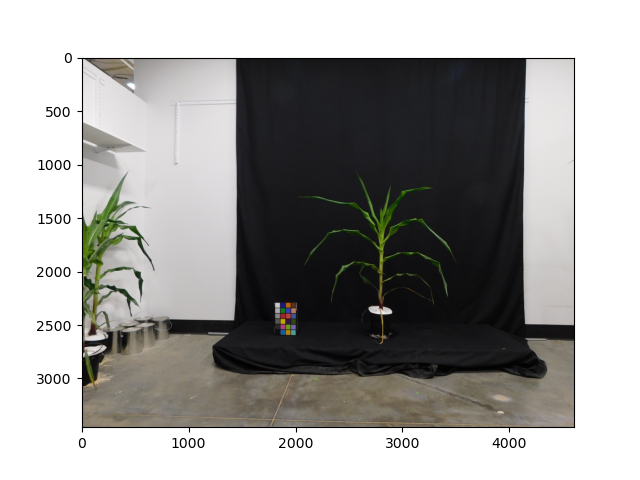

In [5]:
# Read in your image, which is based on the path you put above

# Inputs:
#   filename - Image file to be read in
#   mode - Return mode of image; either 'native' (default), 'rgb', 'gray', or 'csv'
img, path, filename = pcv.readimage(filename=args.image)

## Image Pre-Processing: Cropping and Rotating Images

Take a look at image output produced. With the current layout of the image, how accurate do you think PlantCV's analysis will be given all the extra "noise" in the image (i.e., plants against the wall, empty buckets in the corner, white walls, airducts, and concrete floor). 

Since there is so many extra objects in this image, we will need to [crop](https://plantcv.readthedocs.io/en/stable/crop/) our image so that we can focus more closely on our object-of-interest (maize on the black backdrop). 

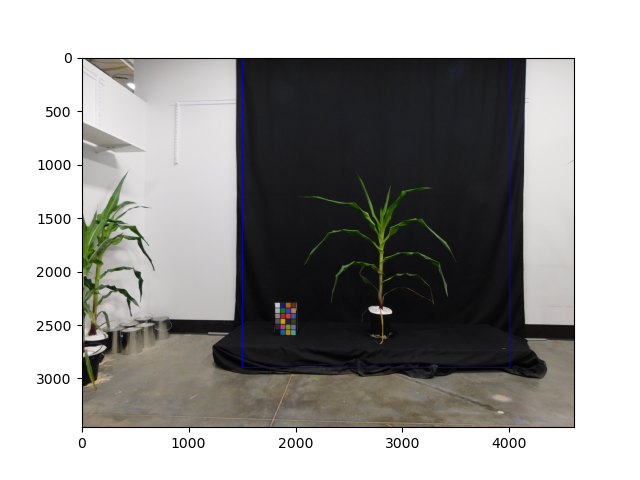

In [6]:
# To crop your object-of-interest, hover your cursor over the image. 
# You will need to record the x- & y-coordinates for the upper-left corner where you will begin cropping your image. 
# Then record the coordinates of the lower-right corner of where your cropping will end.
# Subtract the coordinate values of the lower-right corner from the upper-left corner to 
# obtain the height (h) and width (w).
crop_img = pcv.crop(img=img, x=1500, y=0, h=2900, w=2500)

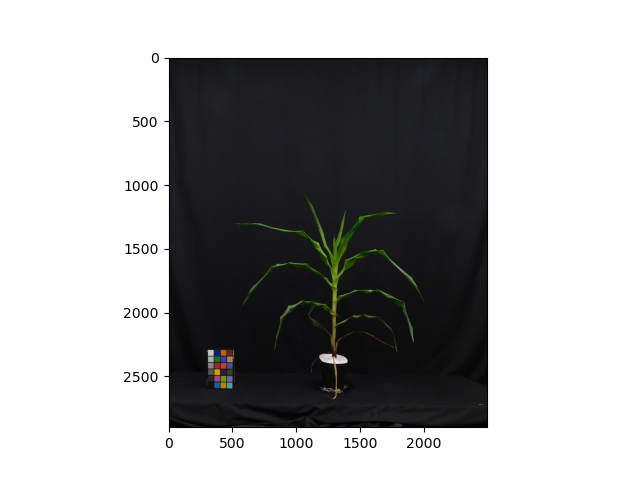

In [7]:
# Sometimes it might be necessary to rotate your image if your camera was not directly facing the sample
# and on a flat surface.
# Our image was captured on a flat surface with our camera directly facing our plant.
# So, we can leave the rotation parameter as 0.
rotate_img = pcv.transform.rotate(crop_img, 0, False)

## Detecting and Calibrating Colors with Color Cards/Color Checkers

Color Cards (or color checkers) are useful reference tools used by imaging experts to calibrate the colors in their images to ensure the accuracy and consistency of color reproduction in their images. The device usually consists of 24 color swatches (or patches) that are designed to mimic a range of colors commonly represented in nature (i.e., skin color, water, leaves, flowers, etc.) in addition to white, gray, and black to balance different lighting conditions. Due to the standardized layout of color cards, they can also be used to calibrate the sizes of other objects in your image so it is imperative that the color card is inline with your object-of-interest. For additional information on how to use a color card, visit the following [article](https://petapixel.com/how-to-use-color-checker-photography/) by Kyle Agee.

In this first step, we will [detect](https://plantcv.readthedocs.io/en/stable/transform_detect_color_card/) our color card. PlantCV can detect color cards automatically using the Transform subpackage, all we need to do is load our image into the function and PlantCV will do the rest. If you know the dimensions of your color card, then you can use it as a scaling factor to determine the measurements of your object-of-interest.

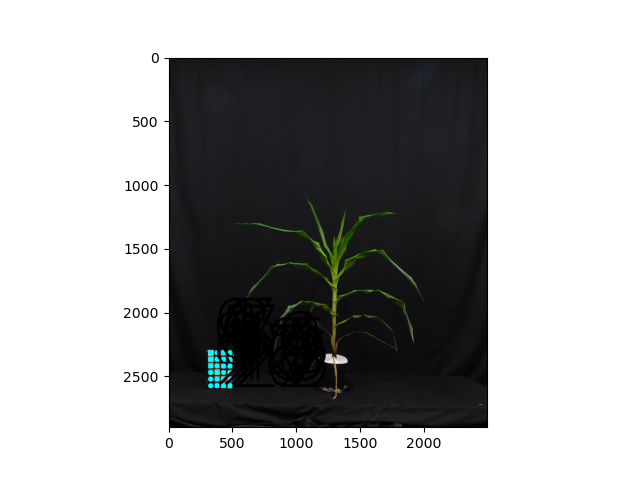

1971.0


In [8]:
# Load your rotated or cropped image into the rgb_img argument to detect the color card.
cc_mask = pcv.transform.detect_color_card(rgb_img=rotate_img)

# We will also print the average chip size and store the values in outputs.observations.
print(pcv.outputs.observations['default']['median_color_chip_size']['value'])

In [9]:
# Next, we make a color card matrix. You will not see an output for this step.

headers, card_matrix = pcv.transform.get_color_matrix(rgb_img=rotate_img, mask=cc_mask)

In [10]:
# Define the standard color card matrix, we know what the colors of those chips should be in a "perfect" image, so we will correct to those values
# Look at where your white chip is in the image to determine which position your card is in (pos)
# When using detect_color_card, you will always set pos=3.

#pos     = reference value indicating orientation of the color card. The reference
       #         is based on the position of the white chip:
        #        pos = 0: bottom-left corner
        #        pos = 1: bottom-right corner
        #        pos = 2: top-right corner
        #        pos = 3: top-left corner

std_color_matrix = pcv.transform.std_color_matrix (pos=3)

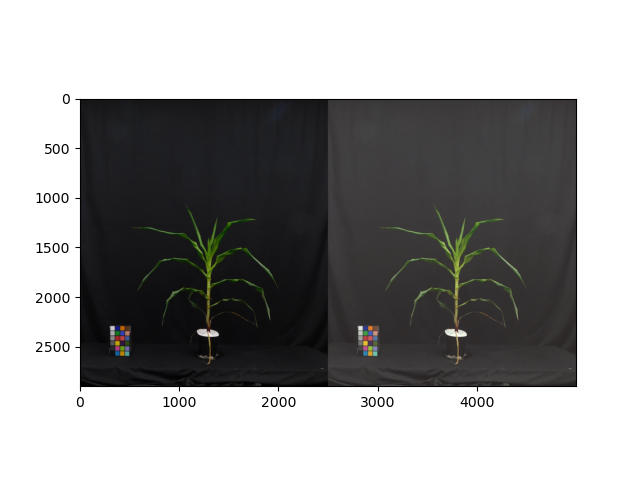

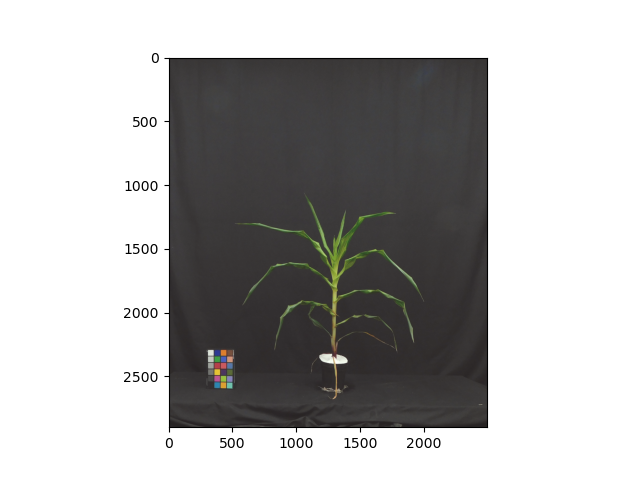

In [11]:
#Color correct your image to the standard values.
#look at the image - does the color look good? 
# If it looks crazy, you probably don't have the card found well and need to go back to 
# define the start and spacing for the card.

img_cc = pcv.transform.affine_color_correction(rotate_img, card_matrix, std_color_matrix)
pcv.plot_image(img_cc)

## Creating a Mask of your Object-of-Interest

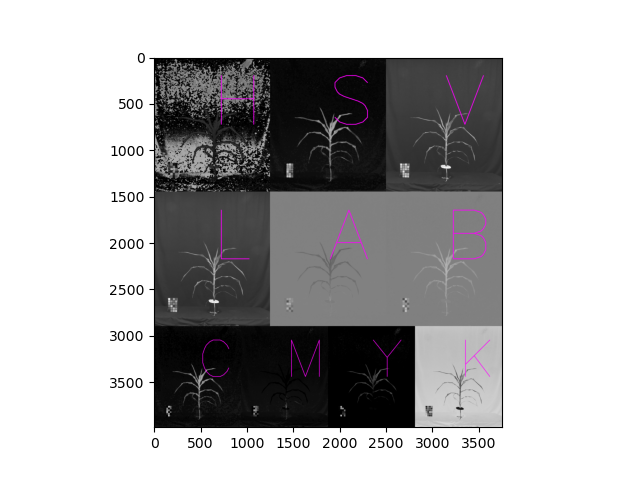

In [12]:
# Update params related to plotting so we can see better
pcv.params.text_size=50
pcv.params.text_thickness=15


#Look at the colorspace - which of these looks the best for masking? Which channel makes the plant look most distinct?
colorspace_img = pcv.visualize.colorspaces(rgb_img=img_cc, original_img=False)

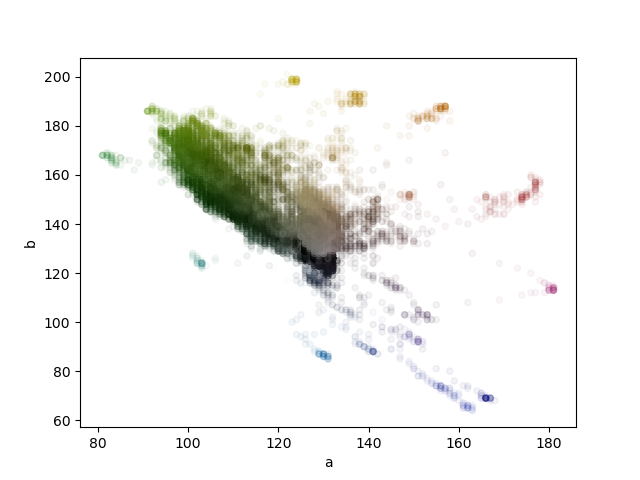

In [13]:
# Look at the colorspaces above and determine which spaces provide you with the greatest contrast of plant vs. background.
# We will use **pcv.visualize.pixel_scatter_plot** to plot the pixel intensities found in those colorspaces on the x- & y- axes. 
# The horizontal and vertical coordinates will represent the pixel intensities from the colorspaces you choose to plot,
# where each dot is given by the original RGB color of the pixel.

# For this image,
color_scatter = pcv.visualize.pixel_scatter_plot(paths_to_imgs = ["./1_B73_sand_C_2023-04-14_10_19_07.jpg"] , x_channel = "a", y_channel ="b" )



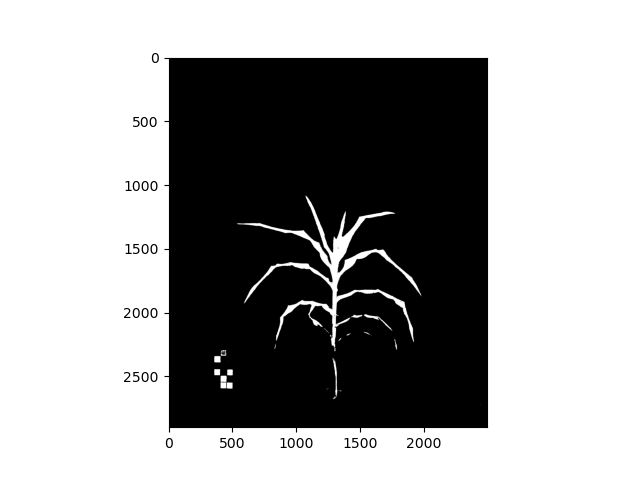

In [14]:
# Threshold your image by choosing points in the plot that will separate the green plant pixels from everything else (hover your mouse over the image).
# It will draw a line between your two points and take every pixel "above" (if set to true). Do you get all of the plant?

thresh1 = pcv.threshold.dual_channels(rgb_img = img_cc, x_channel = "a", y_channel = "b", points = [(80,80),(125,140)], above=True)

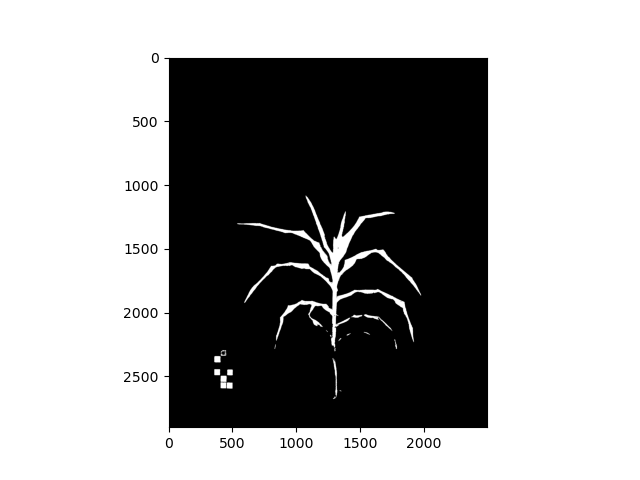

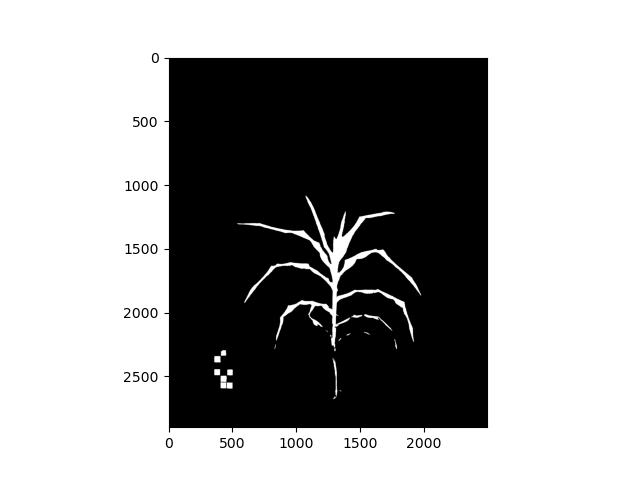

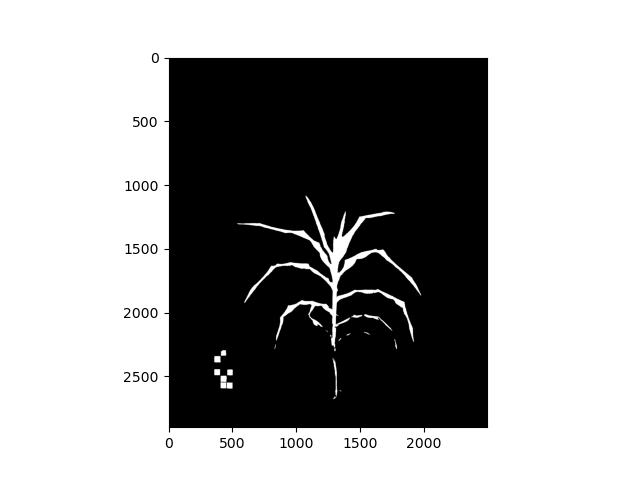

In [15]:
# Fill in small objects if the above threshold looks like there are "holes" in the leaves
a_fill_image = pcv.fill(bin_img=thresh1, size=50)
a_fill_image = pcv.fill_holes(a_fill_image)

pcv.plot_image(a_fill_image)

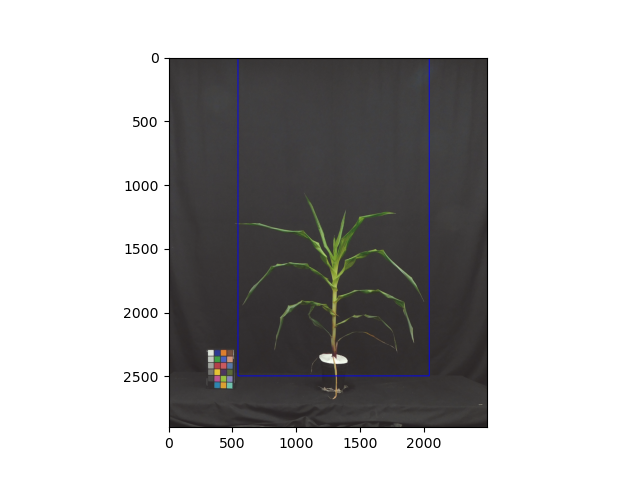

In [16]:
# Define the region of interest (ROI). This should include your plant, but not you color card or other things.

# Inputs:
#   img - RGB or grayscale image to plot the ROI on
#   x - The x-coordinate of the upper left corner of the rectangle
#   y - The y-coordinate of the upper left corner of the rectangle
#   h - The height of the rectangle
#   w - The width of the rectangle

pcv.params.debug = "plot"

roi1 = pcv.roi.rectangle(img=img_cc, x=540, y=0, h=2500, w=1500)

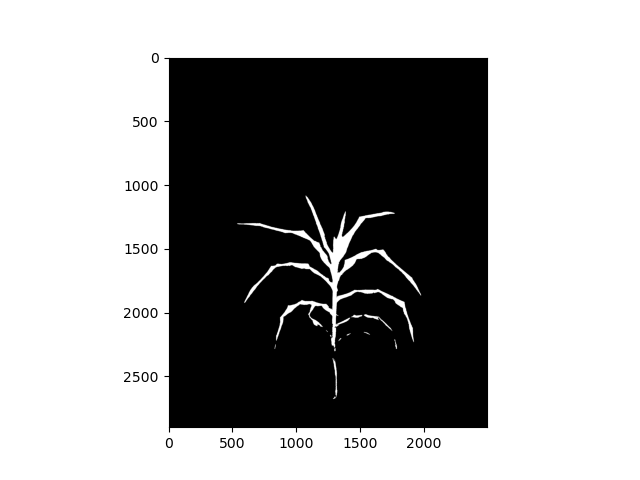

In [17]:
# Make a new filtered mask that only keeps the plant in your ROI and not objects outside of the ROI
# We have set to partial here so that if a leaf extends outside of your ROI it will still be selected. Switch to "cutto" if you have other plants that are getting selected on accident

# Inputs:
#    mask            = the clean mask you made above
#    roi            = the region of interest you specified above
#    roi_type       = 'partial' (default, for partially inside the ROI), 'cutto', or
#                     'largest' (keep only largest contour)

kept_mask  = pcv.roi.(mask=a_fill_image, roi=roi1, roi_type='partial')


## Analyzing Your Mask

In [ ]:
############### Analysis ################

# Find shape properties, data gets stored to an Outputs class automatically

# Inputs:
#   img - RGB or grayscale image data
#   labeled_mask - the mask of each individual object, set by the create_labels function.
#   n_labels - the number of objects, set by the create_labels function.

analysis_image = pcv.analyze.size(img=img_cc, labeled_mask=kept_mask)


In [ ]:
# Shape properties relative to user boundary line (optional). This is useful if your plant is hanging below the pot and you want height from the top of the pot.
# Set your line_position by finding the x-value at the top of the pot, hover your cursor to get that value

# Inputs:
#   img - RGB or grayscale image data
#   obj - Single or grouped contour object
#   mask - Binary mask of selected contours
#   line_position - Position of boundary line (a value of 0 would draw a line
#                   through the bottom of the image)
#   label - Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)filled_img = pcv.morphology.fill_segments(mask=cropped_mask, objects=edge_objects)

boundary_image = pcv.analyze.bound_horizontal(img=img_cc,labeled_mask=kept_mask,
                                               line_position=2380, label="default")


In [ ]:
# Determine color properties: Histograms, Color Slices and Pseudocolored Images, output color analyzed images (optional)

# Inputs:
#   rgb_img - RGB image data
#   mask - Binary mask of selected contours
#   colorspaces - 'all' (default), 'rgb', 'lab', or 'hsv'
#                 This is the data to be printed to the SVG histogram file
#   label - Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)

color_histogram = pcv.analyze.color(rgb_img=img_cc, labeled_mask=kept_mask, colorspaces='all', label="default")


In [ ]:
# The save results function will take the measurements stored when running any PlantCV analysis functions, format,
# and print an output text file for data analysis. The Outputs class stores data whenever any of the following functions
# are ran: analyze_bound_horizontal, analyze_bound_vertical, analyze_color, analyze_nir_intensity, analyze_object,
# fluor_fvfm, report_size_marker_area, watershed. If no functions have been run, it will print an empty text file

#This saves results for one image, and each image is saved individually if you run another image (it will overwrite the last one)
pcv.outputs.save_results(filename=args.result, outformat='csv')


## Congrats, you now know all the settings you like for this day of imaging! It's time to make this into a workflow so that it will analyze all your images at once and you can go relax.